## Анализ процесса электронно-лучевой сварки
### Выпускная квалификационная работа
по курсу "Аналитик данных" Образовательный центр МГТУ им. Н.Э. Баумана - 2022
<br>
<br><b>Выполнил:</b> <i>Альчаков В.В. гр. AD11872/3<i>

### Подключение необходимых библиотек

In [1]:
import pandas as pd
import numpy as np

# Установить точность вывода - 3 знака после запятой
np.set_printoptions(precision = 3, suppress = True)

# sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error as mae

# scipy
from scipy import stats
from scipy.stats import norm

# Библиотеки для работы с графикой
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Работа с ONNX моделями
import onnx
import tf2onnx
import onnxruntime as rt

# Отключение вывода предупреждений
import warnings
warnings.filterwarnings('ignore')

### Геометрические параметры сварного шва
![alt text](img/welding.png "Title")
<i><b>e</b> - Ширина шва</i><br>
<i><b>q</b> - Выпуклость шва</i><br>
<i><b>h</b> - Глубина провара</i><br>
<i><b>t</b> - Толщина шва</i><br>
<i><b>b</b> - Зазор</i><br>
<i><b>S</b> - Толщина свариваемого металла</i><br>

В качестве исходных данных были взяты результаты экспериментальных исследований, проводимых в целях улучшения технологического процесса электронно-лучевой сварки изделия, сборка которого состоит из элементов, состоящих из разнородного материала. Установка электронно-лучевой сварки, на которой проводились исследования, предназначена для сварки электронным лучом в глубоком вакууме деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых и специальных сплавов. Существующая установка электронно-лучевой сварки обеспечивает повторяемость режимов в рамках возможностей реализованной системы управления. Работы по сварке выполнялись на образцах-имитаторах, соответствующих технологическому изделию.

### Загрузка исходного датасета
<b>ВХОД:</b>
<ol>
    <li>IW - Ток сварочного тока</li>
    <li>IF - Ток фокусировки электронного пучка</li>
    <li>VW - Скорость сварки</li>
    <li>FP - Расстояние от поверхности образцов</li>
</ol>
<br>
<b>ВЫХОД:</b>
<ol>
    <li>Depth - Глубина шва</li>
    <li>Width - Ширина шва</li>
</ol>

In [2]:
raw_data = pd.read_csv('data/ebw_data.csv')
raw_data.shape

(72, 6)

### Предварительная обработка и разведовательный анализ

##### Просмотр первых строк датасета

In [3]:
raw_data.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


##### Проверка на наличие пропусков

In [4]:
raw_data.isnull().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

##### Построение обучающей выборки
Анализ датасета показывает, что комбинации значений столбцов IW, IF, VW, FP повторяются. Поэтому построим новый датасет, с уникальными комбинациями признаков и выходным параметром усредненным по каждой группе

In [5]:
train_data = raw_data.groupby(['IW', 'IF', 'VW', 'FP']).agg({'Depth': ['mean'], 'Width': ['mean']}).reset_index()
train_data.columns = ['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']

In [6]:
# Модифицированный датасет для обучения
train_data

,IW,IF,VW,FP,Depth,Width
0,43,146,9.0,60,1.220,1.7650
1,43,150,9.0,50,1.080,1.8150
2,44,146,9.0,60,1.230,1.7950
3,45,140,4.5,80,1.690,2.5100
4,45,140,8.0,80,1.190,1.9700
5,45,141,10.0,80,1.010,1.8600
6,45,146,9.0,60,1.310,1.7600
7,46,141,10.0,80,1.140,1.8200
8,46,146,10.0,60,1.310,1.7700
9,47,134,10.0,110,0.945,1.9350


##### Описательная статистика

In [7]:
train_data.describe()

,IW,IF,VW,FP,Depth,Width
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,45.800000,140.866667,8.866667,80.666667,1.171000,1.957500
std,1.740279,5.462426,2.021904,23.057898,0.229543,0.265678
min,43.000000,131.000000,4.500000,50.000000,0.820000,1.727500
25%,45.000000,139.500000,8.500000,60.000000,1.045000,1.780000
50%,46.000000,141.000000,9.000000,80.000000,1.160000,1.820000
75%,47.000000,146.000000,10.000000,80.000000,1.270000,2.020000
max,49.000000,150.000000,12.000000,125.000000,1.690000,2.515000


##### Расчет корреляционной матрицы
В случае линейной регрессионной модели корреляционная матрица позволит выяснить, какие признаки в большей степени влияют на целевую переменную

In [8]:
# Корреляционная матрица
train_data.corr()

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.844566,0.073079,0.831286,-0.389267,0.359959
IF,-0.844566,1.000000,0.066182,-0.983178,0.452146,-0.501293
VW,0.073079,0.066182,1.000000,0.017364,-0.651087,-0.864309
FP,0.831286,-0.983178,0.017364,1.000000,-0.569981,0.432293
Depth,-0.389267,0.452146,-0.651087,-0.569981,1.000000,0.355843
Width,0.359959,-0.501293,-0.864309,0.432293,0.355843,1.000000


##### Корреляционная матрица в виде тепловой карты

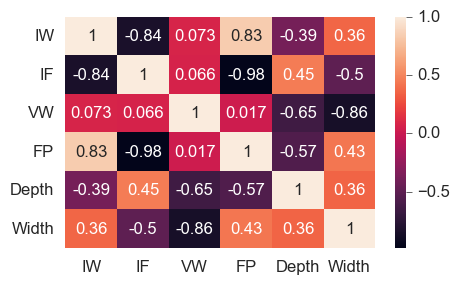

In [9]:
plt.figure(figsize = (5, 3), dpi = 100)
plt.style.use('classic')
sns.set_style('whitegrid')
sns.heatmap(train_data.corr(), annot = True)
plt.show()

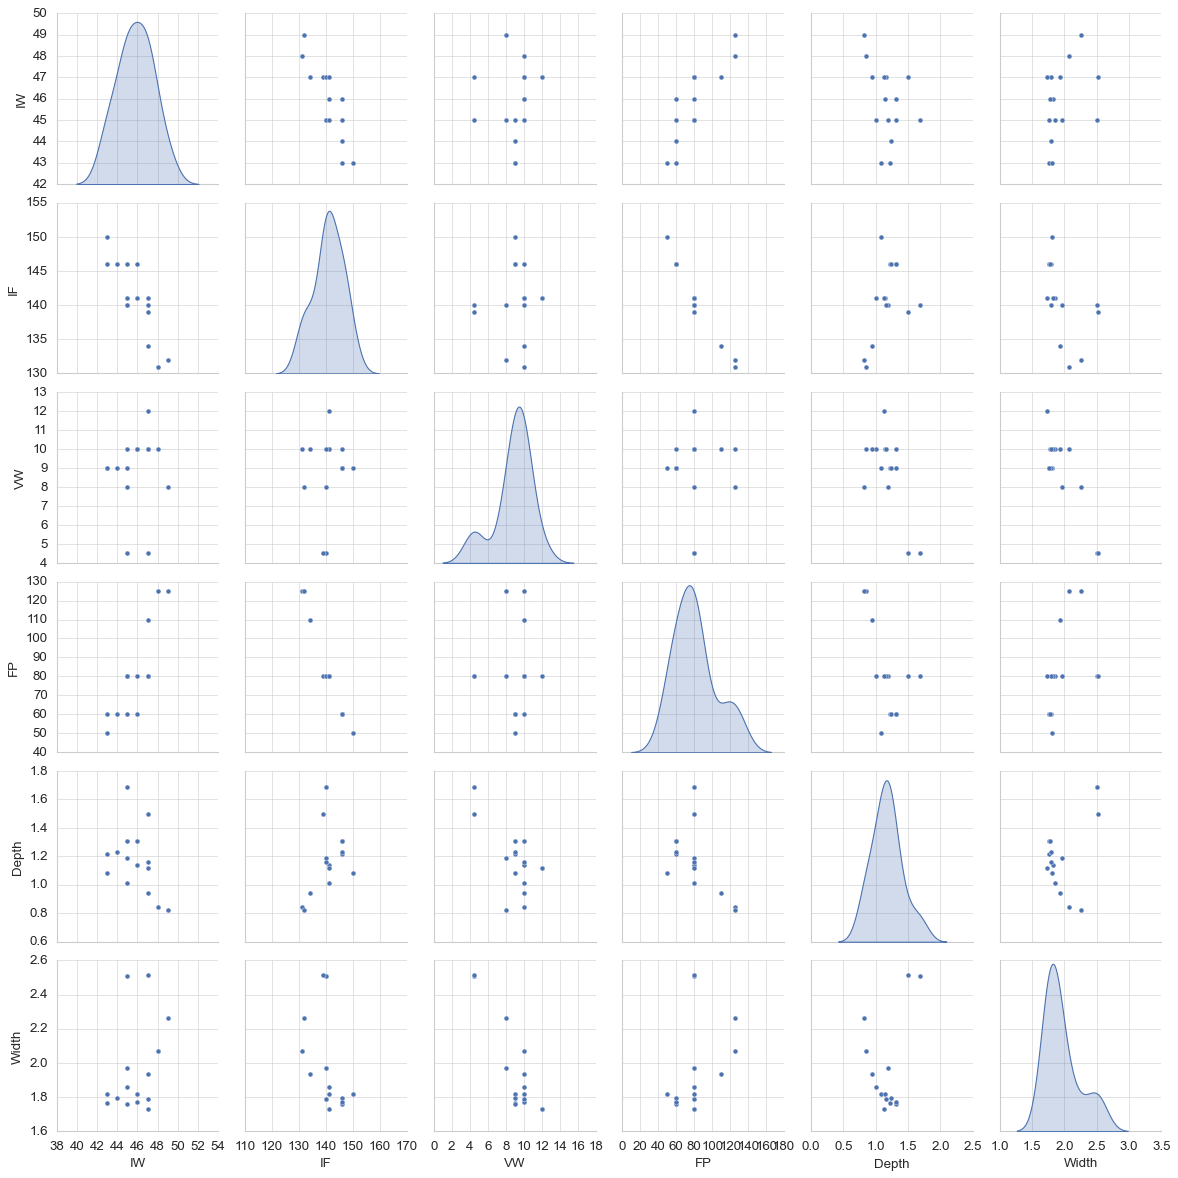

In [10]:
sns.pairplot(train_data[['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']], diag_kind = 'kde')

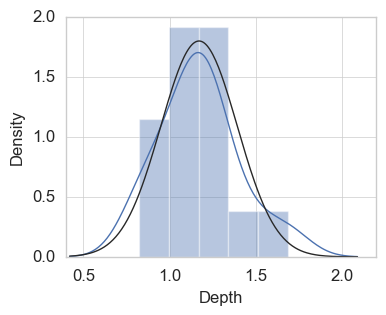

In [11]:
fig = plt.figure(figsize = (4, 3), dpi = 100)
sns.distplot(train_data['Depth'] , fit = norm);

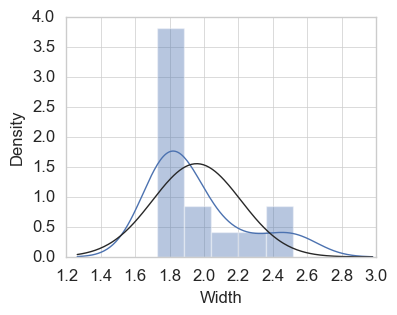

In [12]:
fig = plt.figure(figsize = (4, 3), dpi = 100)
sns.distplot(train_data['Width'] , fit = norm);

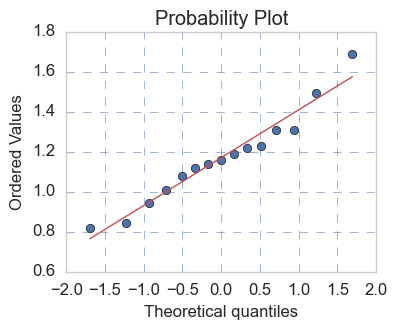

In [13]:
fig = plt.figure(figsize = (4, 3), dpi = 100)
res = stats.probplot(train_data['Depth'], plot = plt)
plt.grid(color = 'b', linestyle = '--', linewidth = 0.5, alpha = .75)
plt.show()

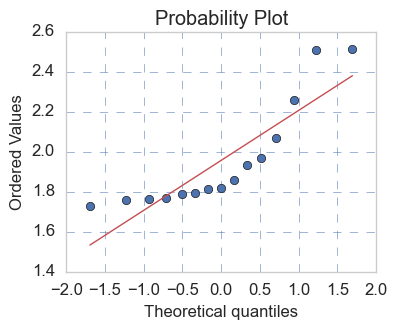

In [14]:
fig = plt.figure(figsize = (4, 3), dpi = 100)
res = stats.probplot(train_data['Width'], plot = plt)
plt.grid(color = 'b', linestyle = '--', linewidth = 0.5, alpha = .75)
plt.show()

##### Разбиваем выборку на массив признаков и вектор со значениями целевой переменной

In [15]:
# Признаки
X = train_data.drop(['Depth', 'Width'], axis = 1)
# Глубина шва
yD = train_data['Depth']
# Ширина шва
yW = train_data['Width']

In [16]:
# Матрица признаков
X.head()

,IW,IF,VW,FP
0,43,146,9.0,60
1,43,150,9.0,50
2,44,146,9.0,60
3,45,140,4.5,80
4,45,140,8.0,80


In [17]:
# Вектор целевая переменная - Глубина шва
yD.head()

0    1.22
1    1.08
2    1.23
3    1.69
4    1.19
Name: Depth, dtype: float64

In [18]:
# Вектор целевая переменная - Ширина шва
yW.head()

0    1.765
1    1.815
2    1.795
3    2.510
4    1.970
Name: Width, dtype: float64

In [19]:
print('Размерности данных (обучающая выборка)')
print(f'Матрица признаков {X.shape}')
print(f'Целевой вектор (глубина шва) {yD.shape}')
print(f'Целевой вектор (ширина шва) {yW.shape}')

Размерности данных (обучающая выборка)
Матрица признаков (15, 4)
Целевой вектор (глубина шва) (15,)
Целевой вектор (ширина шва) (15,)


##### Разбивка данных на выборки для обучения и тестирования

In [20]:
X_train = pd.DataFrame(train_data.iloc[:, 0:4]).values
yD_train = pd.DataFrame(train_data.iloc[:, 4:5]).values
yW_train = pd.DataFrame(train_data.iloc[:, 5:6]).values

X_test = pd.DataFrame(raw_data.iloc[:, 0:4]).values
yD_test = pd.DataFrame(raw_data.iloc[:, 4:5]).values
yW_test = pd.DataFrame(raw_data.iloc[:, 5:6]).values

In [21]:
# Переменные для хранения точности
test_results_width = {}
test_results_depth = {}

##### Функция отрисовки результатов модели

In [22]:
def plt_model(x, y_test, y_predict, title_txt):
    plt.rcParams.update(plt.rcParamsDefault)
    plt.figure(figsize = (10, 4), dpi = 150)
    plt.plot(x, y_test, 'go-', linewidth = 2, markersize = 5)
    plt.plot(x, y_predict, '-r',  linewidth = 2, alpha = .75)
    plt.legend(['Измерения', 'Предсказания'])
    plt.title(title_txt)
    plt.grid(color = 'b', linestyle = '--', linewidth = 0.5, alpha = .75)
    plt.show()

##### Функция обучения модели

In [23]:
def fit_model(pipe, x_train, y_train, x_test, y_test):
    pipe.fit(x_train, y_train)
    y_predict = pipe.predict(x_test)
    x_index = range(y_predict.shape[0])
    mae_value = mae(y_test, y_predict)
    return y_predict, x_index, mae_value

##### Функция сборки и прогона модели

In [24]:
def run_model(pipe, x_train, y_train, x_test, y_test, model_type, model_name):
    y_predict, x_index, mae_value = fit_model(pipe, x_train, y_train, x_test, y_test)
    plt_model(x_index, y_test, y_predict, f'{model_type}: {model_name} Model MAE: {mae(y_test, y_predict):0.3}')
    return mae_value

### Применение метода линейной регрессии для анализа

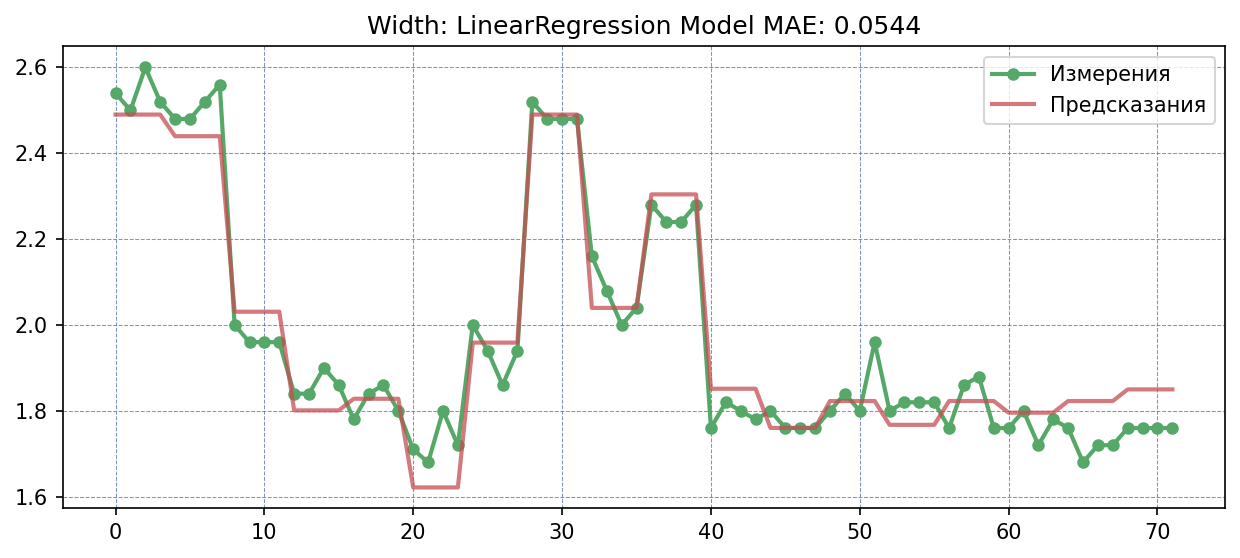

In [25]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
test_results_width['LinearRegression'] = run_model(pipe, X_train, yW_train, X_test, yW_test, 'Width', 'LinearRegression')

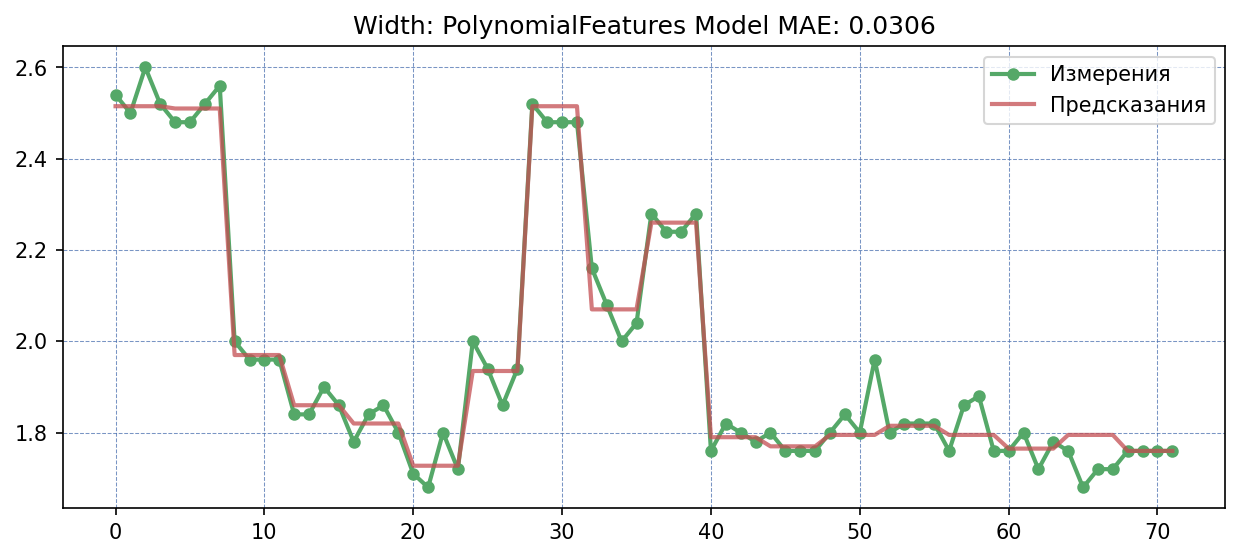

In [26]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())
test_results_width['PolynomialFeatures'] = run_model(pipe, X_train, yW_train, X_test, yW_test, 'Width', 'PolynomialFeatures')

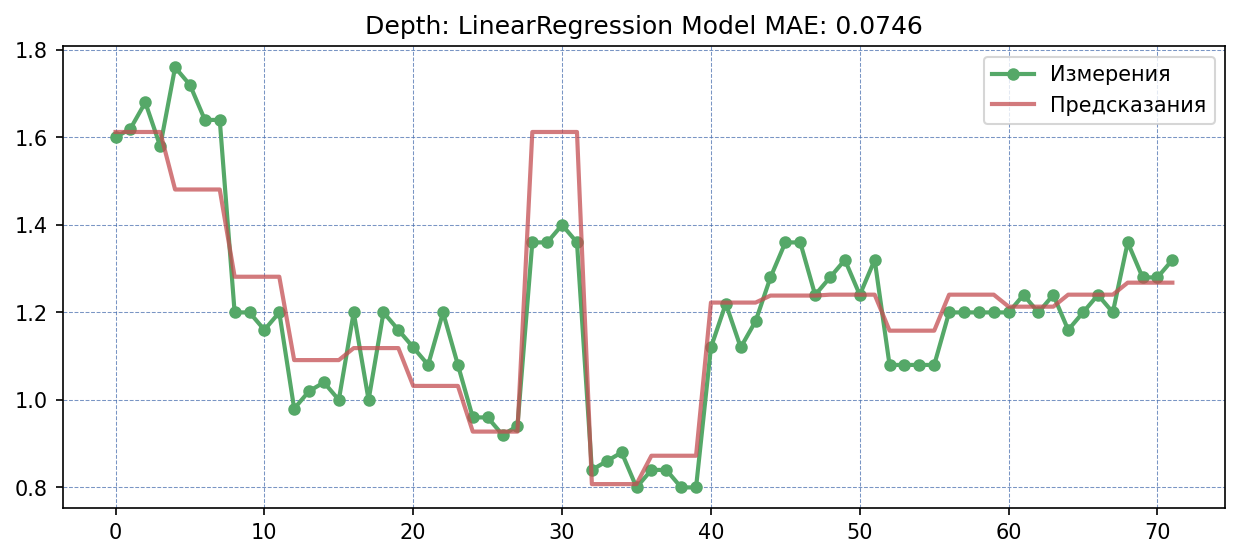

In [27]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
test_results_depth['LinearRegression'] = run_model(pipe, X_train, yD_train, X_test, yD_test, 'Depth', 'LinearRegression')

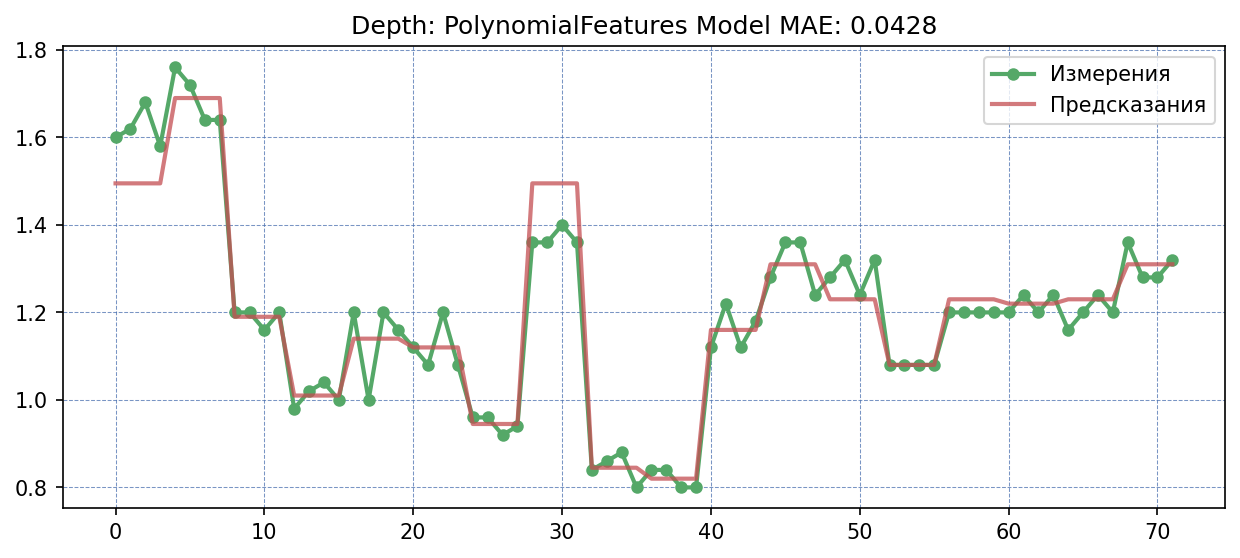

In [28]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())
test_results_depth['PolynomialFeatures'] = run_model(pipe, X_train, yD_train, X_test, yD_test, 'Depth', 'PolynomialFeatures')

### Применение метода опорных векторов для анализа

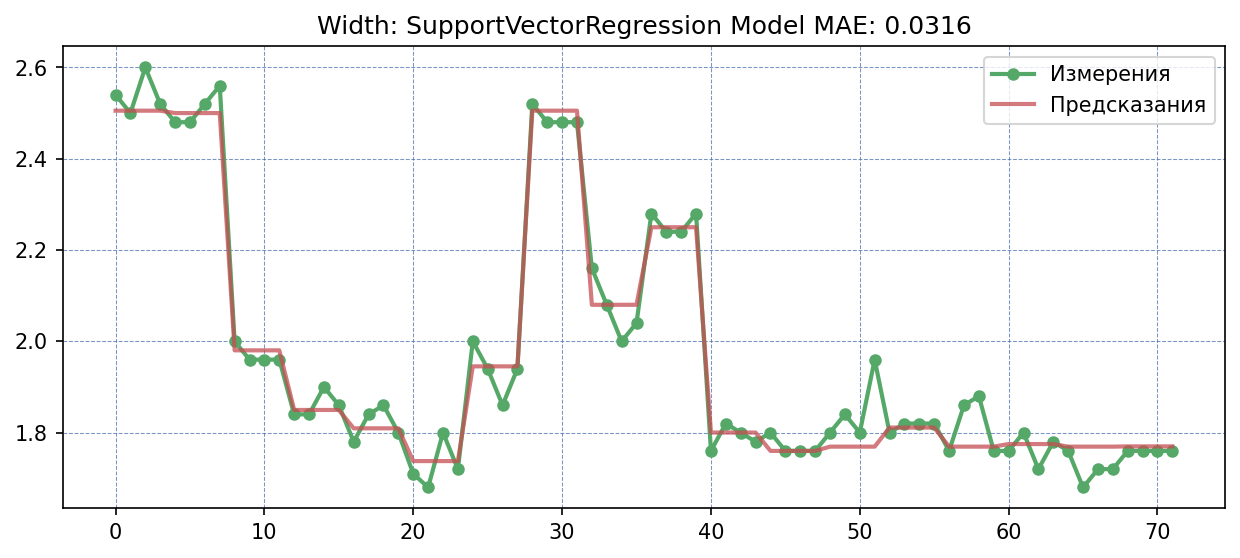

In [29]:
pipe = make_pipeline(StandardScaler(), SVR(C = 1.0, epsilon = 0.01))
test_results_width['SupportVectorRegression'] = run_model(pipe, X_train, yW_train, X_test, yW_test, 'Width', 'SupportVectorRegression')

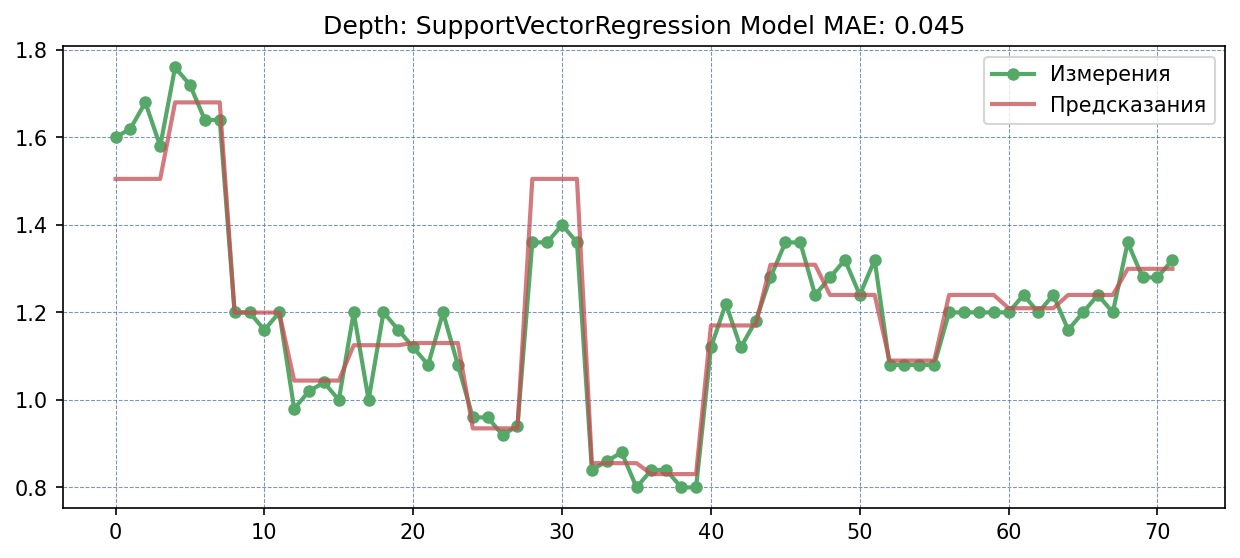

In [30]:
pipe = make_pipeline(StandardScaler(), SVR(C = 1.0, epsilon = 0.01))
test_results_depth['SupportVectorRegression'] = run_model(pipe, X_train, yD_train, X_test, yD_test, 'Depth', 'SupportVectorRegression')

### Применение нейронной сети для анализа

In [31]:
train_features = pd.DataFrame(train_data.iloc[:, 0:4]).values
train_labels = pd.DataFrame(train_data.iloc[:, 4:6]).values
test_features = pd.DataFrame(raw_data.iloc[:, 0:4]).values
test_labels = pd.DataFrame(raw_data.iloc[:, 4:6]).values

In [32]:
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[ 45.8   140.867   8.867  80.667]]


In [33]:
pd.DataFrame(train_data.iloc[:, 0:4]).describe().T

,count,mean,std,min,25%,50%,75%,max
IW,15.0,45.800000,1.740279,43.0,45.0,46.0,47.0,49.0
IF,15.0,140.866667,5.462426,131.0,139.5,141.0,146.0,150.0
VW,15.0,8.866667,2.021904,4.5,8.5,9.0,10.0,12.0
FP,15.0,80.666667,23.057898,50.0,60.0,80.0,80.0,125.0


In [34]:
seq_model = keras.Sequential([normalizer,
                              layers.Dense(64, activation = 'relu'),
                              layers.Dense(32, activation = 'relu'),
                              layers.Dense(2)
                             ])
seq_model.compile(loss = 'mean_absolute_error', optimizer = tf.keras.optimizers.Adam(0.001), metrics = ['accuracy'])
seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2,475
Trainable params: 2,466
Non-trainable params: 9
_________________________________________________________________


In [35]:
history = seq_model.fit(train_features, train_labels, epochs = 1000, verbose = 1, validation_split = 0)

Epoch 1/1000
1/1 [==============================] - 0s 301ms/step - loss: 1.5257 - accuracy: 0.1333
Epoch 2/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.5010 - accuracy: 0.1333
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.4754 - accuracy: 0.1333
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.4495 - accuracy: 0.1333
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.4237 - accuracy: 0.1333
Epoch 6/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.3977 - accuracy: 0.1333
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3714 - accuracy: 0.1333
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3447 - accuracy: 0.1333
Epoch 9/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.3178 - accuracy: 0.1333
Epoch 10/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.2930 - accuracy: 0.1333
Epoch 11/1000
1/1

1/1 [==============================] - 0s 2ms/step - loss: 0.2422 - accuracy: 1.0000
Epoch 84/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2384 - accuracy: 1.0000
Epoch 85/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 1.0000
Epoch 86/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2315 - accuracy: 1.0000
Epoch 87/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2279 - accuracy: 1.0000
Epoch 88/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2243 - accuracy: 1.0000
Epoch 89/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2208 - accuracy: 1.0000
Epoch 90/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2181 - accuracy: 1.0000
Epoch 91/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2146 - accuracy: 1.0000
Epoch 92/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2101 - accuracy: 1.0000
Epoch 93/1000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 0.0492 - accuracy: 1.0000
Epoch 166/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0479 - accuracy: 1.0000
Epoch 167/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0466 - accuracy: 1.0000
Epoch 168/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0449 - accuracy: 1.0000
Epoch 169/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0445 - accuracy: 1.0000
Epoch 170/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0435 - accuracy: 1.0000
Epoch 171/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0432 - accuracy: 1.0000
Epoch 172/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0422 - accuracy: 1.0000
Epoch 173/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0422 - accuracy: 1.0000
Epoch 174/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0400 - accuracy: 1.0000
Epoch 175/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 1.0000
Epoch 248/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0205 - accuracy: 1.0000
Epoch 249/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 1.0000
Epoch 250/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0208 - accuracy: 1.0000
Epoch 251/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 1.0000
Epoch 252/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 1.0000
Epoch 253/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 1.0000
Epoch 254/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 1.0000
Epoch 255/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0196 - accuracy: 1.0000
Epoch 256/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0204 - accuracy: 1.0000
Epoch 257/1000


1/1 [==============================] - 0s 5ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 330/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0102 - accuracy: 1.0000
Epoch 331/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 332/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 333/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 1.0000
Epoch 334/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 335/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 336/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 337/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0086 - accuracy: 1.0000
Epoch 338/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096 - accuracy: 1.0000
Epoch 339/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 412/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 413/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 414/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 415/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 416/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 417/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 418/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 419/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 420/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 421/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 494/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 495/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 496/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 497/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 498/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 499/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 500/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 501/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 502/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 503/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 576/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 577/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 578/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 579/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 580/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 581/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 582/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 583/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 584/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 585/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 658/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 659/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 660/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 661/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 662/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 663/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 664/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 665/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 666/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 667/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 740/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 741/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 742/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 743/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 744/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 745/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 746/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 747/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 748/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 749/1000


1/1 [==============================] - 0s 3ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 822/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 823/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090 - accuracy: 1.0000
Epoch 824/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 825/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 826/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 827/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 828/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 829/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 830/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 831/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 904/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 905/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 906/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 907/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 908/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 909/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 910/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 911/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 912/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 913/1000


1/1 [==============================] - 0s 3ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 986/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 987/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 988/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 989/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 990/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 991/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 992/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 993/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 994/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 995/1000


In [36]:
model_score = seq_model.evaluate(test_features, test_labels, verbose = 0)
print(model_score)

[0.03703201562166214, 1.0]


In [37]:
test_predictions = seq_model.predict(test_features)

3/3 [==============================] - 0s 999us/step


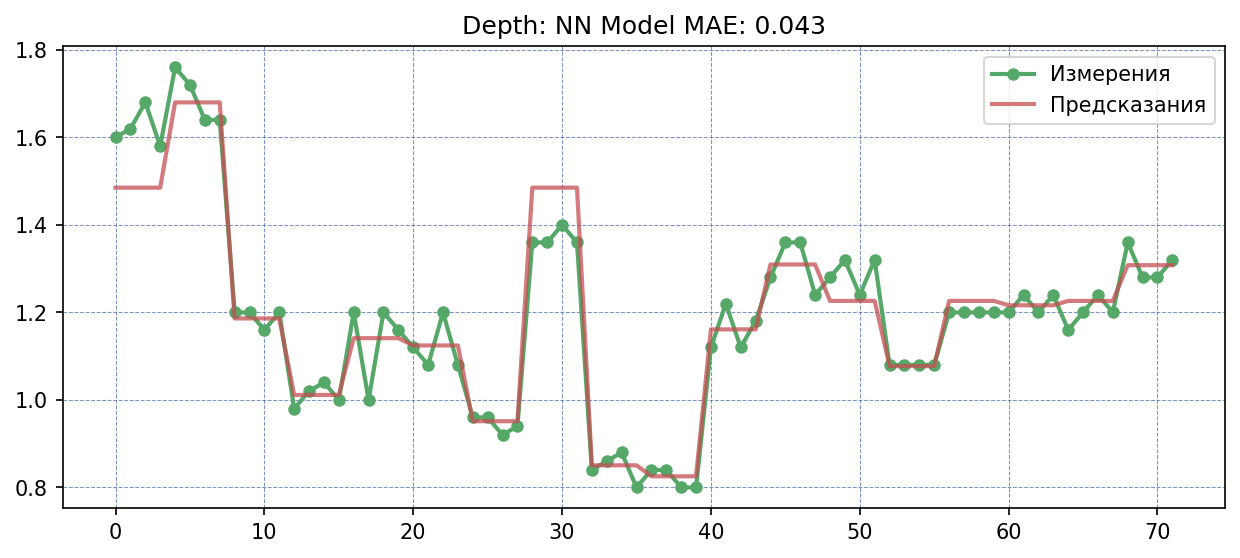

In [38]:
# Анализ Depth
x_predict = range(test_predictions.shape[0])
y_predict = test_predictions[:,:1]
y_test = test_labels[:,:1]
test_results_depth['Neural Network'] = mae(y_test, y_predict)
plt_model(x_predict, y_test, y_predict, f'Depth: NN Model MAE: {mae(y_test, y_predict):0.3}')

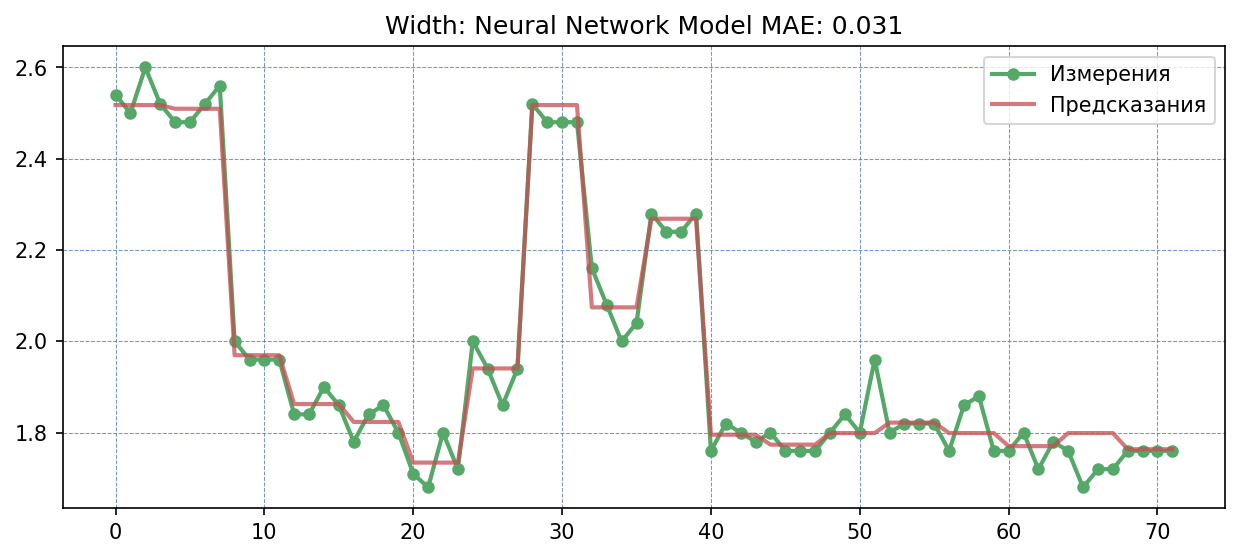

In [39]:
# Анализ Width
x_predict = range(test_predictions.shape[0])
y_predict = test_predictions[:,1:2]
y_test = test_labels[:,1:2]
test_results_width['Neural Network'] = mae(y_test, y_predict)
plt_model(x_predict, y_test, y_predict, f'Width: Neural Network Model MAE: {mae(y_test, y_predict):0.3}')

In [40]:
test_predictions = seq_model.predict(test_features[:1], verbose = 0)
print(f'Параметры: {test_features[:1]}')
print(f'Прогноз: {test_predictions}')
print(f'Истинное значение: {test_labels[:1]}')

Параметры: [[ 47.  139.    4.5  80. ]]
Прогноз: [[1.485 2.518]]
Истинное значение: [[1.6  2.54]]


In [41]:
print("WIDTH")
test_results_width

WIDTH


{'LinearRegression': 0.05442429651267374,
 'PolynomialFeatures': 0.030625000000000013,
 'SupportVectorRegression': 0.03158711796658591,
 'Neural Network': 0.031034815046522352}

In [42]:
print("DEPTH")
test_results_depth

DEPTH


{'LinearRegression': 0.0745975747744926,
 'PolynomialFeatures': 0.04277777777777795,
 'SupportVectorRegression': 0.044957939923193,
 'Neural Network': 0.04302922368049622}

#### Сохранение модели

In [43]:
seq_model.save('model\welding-model')
# Сохранение в формате ONNX
tf2onnx.convert.from_keras(seq_model, output_path = 'model\welding-model.onnx')

INFO:tensorflow:Assets written to: model\welding-model\assets


(ir_version: 7
 producer_name: "tf2onnx"
 producer_version: "1.13.0 2c1db5"
 graph {
   node {
     input: "normalization_input"
     input: "sequential/normalization/sub/y:0"
     output: "sequential/normalization/sub:0"
     name: "sequential/normalization/sub"
     op_type: "Sub"
   }
   node {
     input: "sequential/normalization/sub:0"
     input: "ConstantFolding/sequential/normalization/truediv_recip:0"
     output: "sequential/normalization/truediv:0"
     name: "sequential/normalization/truediv"
     op_type: "Mul"
   }
   node {
     input: "sequential/normalization/truediv:0"
     input: "sequential/dense/MatMul/ReadVariableOp:0"
     output: "sequential/dense/MatMul:0"
     name: "sequential/dense/MatMul"
     op_type: "MatMul"
   }
   node {
     input: "sequential/dense/MatMul:0"
     input: "sequential/dense/BiasAdd/ReadVariableOp:0"
     output: "sequential/dense/BiasAdd:0"
     name: "sequential/dense/BiasAdd"
     op_type: "Add"
   }
   node {
     input: "sequential

#### Загрузка сохраненной модели и тестовый запуск

In [44]:
# Создание переменной сессии для работы с моделью (загрузка модели)
session = rt.InferenceSession('model\welding-model.onnx')
# Создание вектора для параметров
X = np.array([[47.0, 139.0, 4.5, 80.0]], dtype = np.float32)
inputDetails = session.get_inputs()
# Получение прогозна
y = session.run(None, {inputDetails[0].name: X})
print(y)

[array([[1.485, 2.518]], dtype=float32)]
